# Job Search

We solve the job search problem with Bellman equation

$$ 
    v(w) = \max 
    \left\{ 
        \frac{w}{1-\beta},
        c + \beta \sum_{w'} v(w') \phi(w')
    \right\}
$$

and Bellman operator

$$ 
    v(w) = \max 
    \left\{ 
        \frac{w}{1-\beta},
        c + \beta \sum_{w'} v(w') \phi(w')
    \right\}
$$

We will make use of the following function, which implements successive approximation:

In [3]:
# %load ../solvers.py
import numpy as np
def successive_approx(T,                     # Operator (callable)
                      x_0,                   # Initial condition
                      tolerance=1e-6,        # Error tolerance
                      max_iter=10_000,       # Max iteration bound
                      print_step=25,         # Print at multiples
                      verbose=False):        
    x = x_0
    error = tolerance + 1
    k = 1
    while error > tolerance and k <= max_iter:
        x_new = T(x)
        error = np.max(np.abs(x_new - x))
        if verbose and k % print_step == 0:
            print(f"Completed iteration {k} with error {error}.")
        x = x_new
        k += 1
    if error > tolerance:
        print(f"Warning: Iteration hit upper bound {max_iter}.")
    elif verbose:
        print(f"Terminated successfully in {k} iterations.")
    return x



We also use these imports:

In [7]:
from scipy.stats import betabinom
from collections import namedtuple
import matplotlib.pyplot as plt

### Set Up

We introduce a `namedtuple` that stores the data for solving the problem:

In [5]:
Model = namedtuple("Model", ("w_vals", "φ", "β", "c")) 

The next function generates an instance of the named tuple with default values.

In [8]:
def create_job_search_model(
        n=50,        # wage grid size
        w_min=10.0,  # lowest wage
        w_max=60.0,  # highest wage
        a=200,       # wage distribution parameter
        b=100,       # wage distribution parameter
        β=0.96,      # discount factor
        c=10.0       # unemployment compensation
    ):
    w_vals = np.linspace(w_min, w_max, n+1)
    φ = np.array([betabinom(n, a, b).pmf(k) for k in range(n+1)])
    return Model(w_vals=w_vals, φ=φ, β=β, c=c)

Here's an instance:

In [13]:
model = create_job_search_model()

We can access data by name:

In [14]:
model.c, model.β

(10.0, 0.96)

Or we can unpack all at once:

In [17]:
w_vals, ϕ, β, c = model

In [18]:
c, β

(10.0, 0.96)

As an exercise, let's plot the default wage offer distribution.

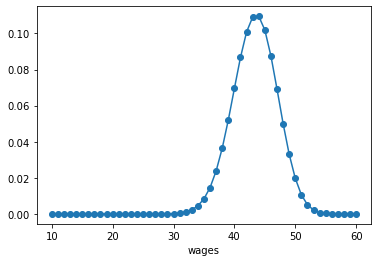

In [21]:
fig, ax = plt.subplots()
ax.plot(w_vals, ϕ, '-o')
ax.set_xlabel("wages")
plt.show()

## Value Function Iteration

Let's solve the problem by VFI

In [32]:
def T(v, model):
    w_vals, ϕ, β, c = model
    stopping_vals = w_vals / (1 - β)
    continuation_val = c + β * v @ ϕ
    return np.maximum(stopping_vals, continuation_val)

def get_greedy(v, model):
    w_vals, ϕ, β, c = model
    stopping_vals = w_vals / (1 - β)
    continuation_val = c + β * v @ ϕ
    return np.where(stopping_vals > continuation_val, 1, 0)


def vfi(model):
    v_0 = np.zeros_like(model.w_vals)
    _T = lambda v: T(v, model)
    v = successive_approx(_T, v_0, verbose=True)
    σ = get_greedy(v, model)
    return v, σ

In [33]:
model = create_job_search_model()
v, σ = vfi(model)

Completed iteration 25 with error 2.2046856429369655e-06.
Terminated successfully in 28 iterations.


## Exercise: Solve for the Continuation Value

The function $g(h) = c + \beta \sum_{w'} \max\{w'/(1-\beta), h\} \phi(w')$.  The fixed point is the continuation value.

In [5]:
def g(h, model):
    w_vals, φ, β, c = model.w_vals, model.φ, model.β, model.c
    return c + β * np.maximum(w_vals / (1 - β), h) @ φ

Task: Plot the fixed point $h^*$ of $g$ as a function of $\beta$.  Use the values

In [6]:
betas = np.linspace(0.9, 0.99, 20) 

## Solution

In [7]:
def compute_hstar(model, h_init=0.0):
    h_star = successive_approx(lambda h: g(h, model), h_init)
    return h_star

In [8]:
h_vals = np.empty_like(betas)
for i, β in enumerate(betas):
    model = create_job_search_model(β=β)
    h = compute_hstar(model)
    h_vals[i] = h

Terminated successfully in 13 iterations.
Terminated successfully in 13 iterations.
Terminated successfully in 13 iterations.
Terminated successfully in 13 iterations.
Terminated successfully in 15 iterations.
Terminated successfully in 16 iterations.
Terminated successfully in 16 iterations.
Terminated successfully in 16 iterations.
Terminated successfully in 19 iterations.
Terminated successfully in 20 iterations.
Terminated successfully in 20 iterations.
Terminated successfully in 21 iterations.
Terminated successfully in 26 iterations.
Terminated successfully in 27 iterations.
Terminated successfully in 27 iterations.
Terminated successfully in 36 iterations.
Terminated successfully in 38 iterations.
Terminated successfully in 51 iterations.
Terminated successfully in 55 iterations.
Terminated successfully in 82 iterations.


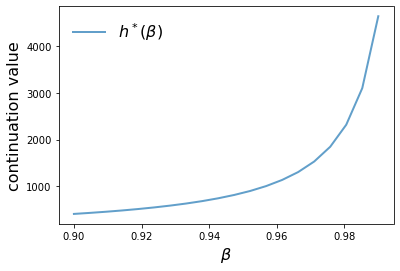

In [9]:
fs = 16
fig, ax = plt.subplots()
ax.plot(betas, h_vals, lw=2.0, alpha=0.7, label="$h^*(\\beta)$")
ax.legend(frameon=False, fontsize=fs)
ax.set_xlabel("$\\beta$", fontsize=fs)
ax.set_ylabel("continuation value", fontsize=fs)
plt.show()